In [1]:
# Alan Raydan
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim import Adam
import itertools

# Error Estimates for Physics Informed Neural Networks Approximating the Primitive Equations

$$
\begin{align*}
    &u_t + uu_z +wu_z - \nu_h u_{xx} - \nu_z u_{zz} + p_x = 0\\
    &p_z + T = 0\\
    &u_x + w_z = 0\\
    &T_t + uT_x + wT_z - \kappa_h T_{xx} - \kappa T_{zz} = Q
\end{align*}
$$

## Feedforward Neural Network with tanh activation functions
Here we use a standard feedforward network with 2 hidden layers, 128 nodes per layer, and tanh activation functions.

In [7]:
class Mlp(nn.Module):
    """
    A simple multilayer perceptron architecture with 2 hidden layers and
    tanh activation functions.
    """
    def __init__(self, spacial_dim):
        super().__init__()
        self.spacial_dim = spacial_dim
        self.net = nn.Sequential(
            nn.Linear(1 + self.spacial_dim, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 1))

    def forward(self, t, *x):
        # add assert statement to ensure appropriate dimension of x equals self.spacial_dim
        tx = torch.cat((t, *x), dim=1)
        return self.net(tx)


class PrimitiveNet():
    """
    A class consisting of our 4 NNs which will be trained to satisfy
    the primitive equations.
    """
    def __init__(self, spacial_dim, Q, v_z, v_h, k_z, k_h, lr):
        self.u_net = Mlp(spacial_dim)
        self.w_net = Mlp(spacial_dim)
        self.p_net = Mlp(spacial_dim)
        self.T_net = Mlp(spacial_dim)
        all_params = itertools.chain(self.u_net.parameters(), self.w_net.parameters(), self.p_net.parameters(), self.T_net.parameters())
        self.optimizer = Adam(all_params, lr)
        self.Q = Q
        self.v_z = v_z
        self.v_h = v_h
        self.k_z = k_z
        self.k_h = k_h

    def generate_interior_residuals(self, quad_points):
        t, x, z = quad_points
        tt, xx, zz = torch.meshgrid(t, x, z, indexing="ij")
        tt = tt.reshape((-1, 1)).requires_grad_()
        xx = xx.reshape((-1, 1)).requires_grad_()
        zz = zz.reshape((-1, 1)).requires_grad_()

        # Forward pass
        u = self.u_net(tt, xx, zz)
        w = self.w_net(tt, xx, zz)
        p = self.p_net(tt, xx, zz)
        T = self.T_net(tt, xx, zz)

        # Compute required derivatives
        u_t = torch.autograd.grad(torch.sum(u), tt, create_graph=True)[0]
        u_x = torch.autograd.grad(torch.sum(u), xx, create_graph=True)[0]
        u_z = torch.autograd.grad(torch.sum(u), zz, create_graph=True)[0]
        u_xx = torch.autograd.grad(torch.sum(u_x), xx, create_graph=True)[0]
        u_zz = torch.autograd.grad(torch.sum(u_z), zz, create_graph=True)[0]
        w_z = torch.autograd.grad(torch.sum(w), zz, create_graph=True)[0]
        p_x = torch.autograd.grad(torch.sum(p), xx, create_graph=True)[0]
        p_z = torch.autograd.grad(torch.sum(p), zz, create_graph=True)[0]
        T_t = torch.autograd.grad(torch.sum(T), tt, create_graph=True)[0]
        T_x = torch.autograd.grad(torch.sum(T), xx, create_graph=True)[0]
        T_z = torch.autograd.grad(torch.sum(T), zz, create_graph=True)[0]
        T_xx = torch.autograd.grad(torch.sum(T_x), xx, create_graph=True)[0]
        T_zz = torch.autograd.grad(torch.sum(T_z), zz, create_graph=True)[0]

        # Evaluate residuals
        R_i_u = u_t + u*u_x + w*u_z - self.v_h*u_xx - self.v_z*u_zz + p_x
        R_i_p = p_z + T
        R_i_div = u_x + w_z
        R_i_T = T_t + u*T_x + w*T_z - self.k_h*T_xx - self.k_z*T_zz - Q(tt, xx, zz)

        return R_i_u, R_i_p, R_i_div, R_i_T

    def generate_boundary_residuals(self, quad_points):
        t, x, z = quad_points
        tt, xx = torch.meshgrid(t, x, indexing="ij")
        _, zz = torch.meshgrid(t, z, indexing="ij")
        tt = tt.reshape((-1, 1))
        xx = xx.reshape((-1, 1))
        zz = zz.reshape((-1, 1))
        zero = torch.zeros_like(xx)
        one = torch.ones_like(xx)

        # Boundary conditions for w
        wt1z = self.w_net(tt, one, zz)
        wt0z = self.w_net(tt, zero, zz)
        wtx1 = self.w_net(tt, xx, one)
        wtx0 = self.w_net(tt, xx, zero)
        wR_s_o = ((wt1z - wt0z).pow(2) + wtx1.pow(2) + wtx0.pow(2)).pow(0.5)

        # Boundary conditions for T
        Tt1z = self.T_net(tt, one, zz)
        Tt0z = self.T_net(tt, zero, zz)
        Ttx1 = self.T_net(tt, xx, one)
        Ttx0 = self.T_net(tt, xx, zero)
        TR_s_o = ((Tt1z - Tt0z).pow(2) + Ttx1.pow(2) + Ttx0.pow(2)).pow(0.5)

        # Boundary conditions for u
        ut1z = self.u_net(tt, one, zz)
        ut0z = self.u_net(tt, zero, zz)
        utx1 = self.u_net(tt, xx, one)
        utx0 = self.u_net(tt, xx, zero)
        zero.requires_grad_()
        one.requires_grad_()
        u_0 = self.u_net(tt, xx, zero)
        u_1 = self.u_net(tt, xx, one)
        u_z0 = torch.autograd.grad(torch.sum(u_0), zero, create_graph=True)[0]
        u_z1 = torch.autograd.grad(torch.sum(u_1), one, create_graph=True)[0]
        uR_s_e = ((ut1z - ut0z).pow(2) + (utx1 - utx0).pow(2) + u_z0.pow(2) + u_z1.pow(2)).pow(0.5)

        # Boundary conditions for p
        pt1z = self.p_net(tt, one, zz)
        pt0z = self.p_net(tt, zero, zz)
        ptx1 = self.p_net(tt, xx, one)
        ptx0 = self.p_net(tt, xx, zero)
        p_0 = self.p_net(tt, xx, zero)
        p_1 = self.p_net(tt, xx, one)
        p_z0 = torch.autograd.grad(torch.sum(p_0), zero, create_graph=True)[0]
        p_z1 = torch.autograd.grad(torch.sum(p_1), one, create_graph=True)[0]
        pR_s_e = ((pt1z - pt0z).pow(2) + (ptx1 - ptx0).pow(2) + p_z0.pow(2) + p_z1.pow(2)).pow(0.5)

        return wR_s_o, TR_s_o, uR_s_e, pR_s_e

    def generate_initial_residuals(self, quad_points):
        x, z = quad_points
        xx, zz = torch.meshgrid(x, z, indexing="ij")
        xx = xx.reshape((-1, 1))
        zz = zz.reshape((-1, 1))
        zero = torch.zeros_like(xx)

        # Initial condition for u
        u_init = -torch.sin(np.pi * xx) * torch.cos(np.pi * zz)
        u_0 = self.u_net(zero, xx, zz)
        R_t_u = u_0 - u_init

        # Initial condition for T
        T_0 = self.T_net(zero, xx, zz)
        R_t_T = T_0

        return R_t_u, R_t_T

    def plot_networks(self, times, nets):
        x_vals = torch.linspace(0.0, 1.0, 100)
        z_vals = torch.linspace(0.0, 1.0, 100)
        XX, ZZ = torch.meshgrid(x_vals, z_vals, indexing="ij")
        x = XX.reshape((-1, 1))
        z = ZZ.reshape((-1, 1))
        fig = plt.figure(figsize=(20, 15))
        count = 1
        for i in range(len(nets)):
            for j, time in enumerate(times):
                t = time * torch.ones_like(x)
                with torch.no_grad():
                    output = nets[i](t, x, z)
                    output = output.reshape(XX.shape)
                ax = fig.add_subplot(4, len(times), count, projection='3d')
                ax.set_xlabel('x')
                ax.set_ylabel('z')
                ax.set_title(f'Equation {i} at t = {time}')
                ax.plot_surface(XX, ZZ, output)
                count += 1

## Helper functions
Functions to generate the quadrature points for the midpoint rule and the necessary residuals for the primitive equations.

These residuals are taken directly from the overleaf draft, and I try to stick to the notation used in the paper. I can change them if we decide on different residuals in the future.

In [3]:
def generate_quadrature_points(points_per_dimension, min, max):
    """
    Generates an equal number of points in each dimension according to midpoint quadrature method
    where the interval in each dimension is of the form [min, max].
    """
    midpoint_shift = (max - min) / (2 * (points_per_dimension - 1))
    shifted_min = min + midpoint_shift
    shifted_max = max + midpoint_shift
    t = torch.linspace(shifted_min, shifted_max, steps=points_per_dimension)
    x = torch.linspace(shifted_min, shifted_max, steps=points_per_dimension)
    z = torch.linspace(shifted_min, shifted_max, steps=points_per_dimension)
    return t, x, z

## Main learning loop

Here we consider Taylor-Green vortex where $\nu_z = \nu_h = \kappa_z = \kappa_h = 1$ and $Q(t, x, z) = 0$.

The PINN-NSE paper uses 80,000 training epochs, but this would take a long time on my machine. I might try it out anyway but it may not be necessary. The learning rate and number of quadrature points are also taken from the PINN-NSE paper as well as the choice of the midpoint rule for the quadrature.

In [9]:
# Problem parameters
lr = 8e-4
epochs = int(5e3)
spacial_dim = 2
domain_min = 0.0
domain_max = 1.0
num_quad_points = 30
v_z = 1.0
v_h = 1.0
k_z = 1.0
k_h = 1.0
Q = lambda t, x, z: torch.tensor(0.0)

# Initializations
model = PrimitiveNet(spacial_dim, Q, v_z, v_h, k_z, k_h, lr)
t, x, z = generate_quadrature_points(num_quad_points, domain_min, domain_max)
errors = []

# Main training loop
for i in range(epochs):

    R_i_u, R_i_p, R_i_div, R_i_T = model.generate_interior_residuals((t, x, z))
    uR_s_e, wR_s_o, pR_s_e, TR_s_o = model.generate_boundary_residuals((t, x, z))
    R_t_u, R_t_T = model.generate_initial_residuals((x, z))

    E_i = torch.sum(R_i_u.pow(2) + R_i_p.pow(2) + R_i_div.pow(2) + R_i_T.pow(2)) / num_quad_points**3
    E_s = torch.sum(uR_s_e.pow(2) + wR_s_o.pow(2) + pR_s_e.pow(2) + TR_s_o.pow(2)) / num_quad_points**2
    E_t = torch.sum(R_t_u.pow(2) + R_t_T.pow(2)) / num_quad_points**2
    training_error = E_i + E_s + E_t

    training_error.backward()
    model.optimizer.step()
    model.optimizer.zero_grad()

    errors.append(training_error.detach())

## Epoch vs. Training Error

Training error at final epoch: 0.026590095832943916


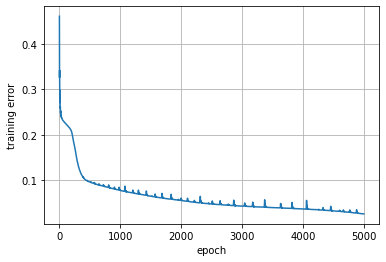

In [10]:
plt.plot(errors)
plt.xlabel("epoch")
plt.ylabel("training error")
plt.grid()

print(f"Training error at final epoch: {errors[-1]}")

## Plots of Learned Functions
Each row corresponds to a different function at three times.

From top to bottom, the functions are $u$, $w$, $p$, and $T$

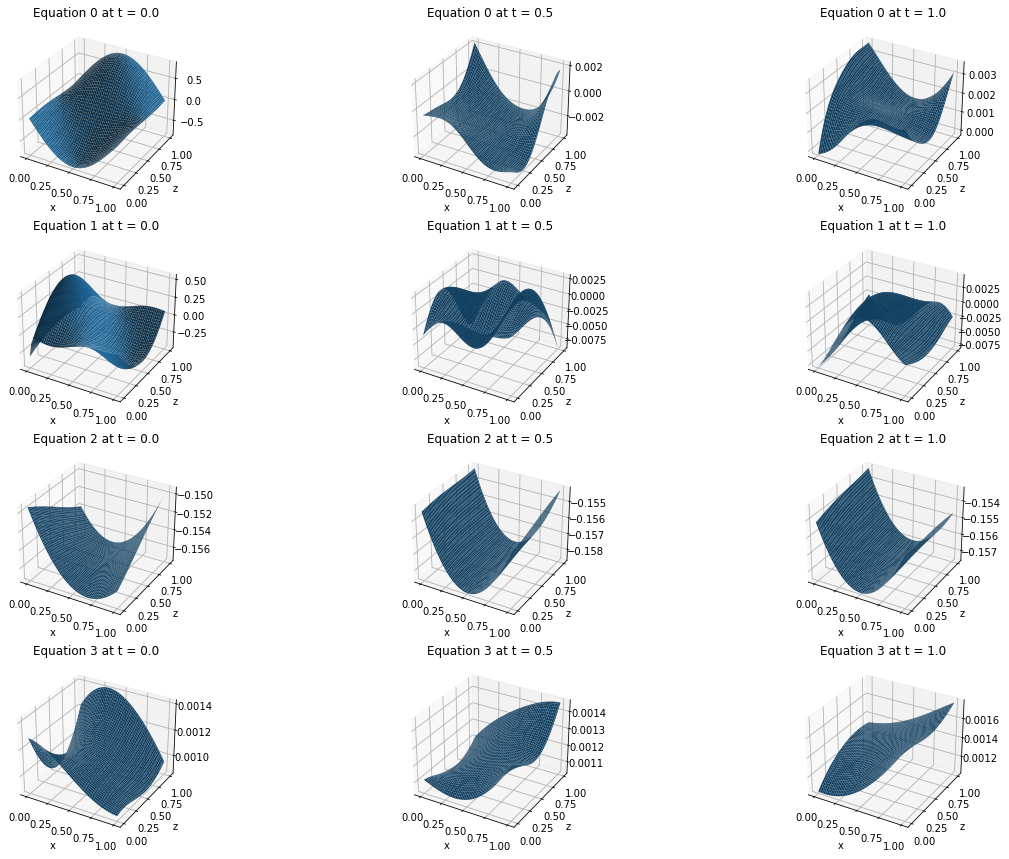

In [11]:
times = torch.tensor([0.0, 0.5, 1.0])
model.plot_networks(times, (model.u_net, model.w_net, model.p_net, model.T_net))